## Theory
The term 'fractal dimension' was introduced by Benoit Mandelbrot in 1967 to explain self-similarity of a pattern. A fractal dimension is defined as a ratio of the change in detail to the change in scale. It is used as an index that quantifies the complexity of a fractal pattern (https://en.wikipedia.org/wiki/Fractal_dimension). 

Famously, fractal dimension has been described in the context of the British coastline. A coastline's measured length was observed to change depending on the length of the measuring stick used. In 2-D and 3-D, this notion can be extended to the length of a measuring pixel or voxel, respectively. 


![image.png](attachment:image.png)
http://en.wikipedia.org/wiki/Image:Britain-fractal-coastline-combined.jpg 

### Box Counting Method
One way to determine fractal dimension of an image is through the box counting method. Measuring elements are laid over the image in a fixed grid pattern. As it scans over the grid, information is collected as to whether or not the measuring element is at the edge of the pattern. The number of measuring elements that are at the edge is then used to calculate the fractal dimension (https://en.wikipedia.org/wiki/Box_counting). 

## Mathematical Definition
The relationship of a pattern's fractal dimension and its measuring element can be expressed as:

$N	\propto \frac{1}{D^F}$

$F = \lim_{D \to 0} \frac{-log N(D)}{log(D)}$

* N: number of measuring elements
* D: size of measuring element
* F: fractal dimension

## Example
A Sierpinski carpet has a known fractal dimension of 1.8928. Performing the box counting method found its fractal dimension as approximately 1.8 ~ 1.9.

First, import the needed packages.


In [6]:
import matplotlib.pyplot as plt
import porespy as ps
import numpy as np
import scipy.ndimage as spim 
import scipy.signal as spsig
from tqdm import tqdm
import skimage
from skimage.morphology import square
import imageio
from porespy.filters import fftmorphology
import math

In [3]:
def sierpinski_foam(dmin, n, ndim=2, max_size=1e9):
    r"""
    Generates an image of a Sierpinski carpet or foam

    Parameters
    ----------
    dmin : int
        The size of the smallest square in the final image
    n : int
        The number of times to iteratively tile the image
    ndim : int
        The number of dimensions of the desired image, can be 2 (default) or 3

    Returns
    -------
    foam : ND-array
        A boolean image of a Sierpinski gasket or foam

    """
    def _insert_cubes(im, n):
        if n > 0:
            n -= 1
            shape = np.asarray(np.shape(im))
            im = np.tile(im, (3, 3, 3))
            im[shape[0]:2*shape[0], shape[1]:2*shape[1], shape[2]:2*shape[2]] = 0
            if im.size < max_size:
                im = _insert_cubes(im, n)
        return im

    def _insert_squares(im, n):
        if n > 0:
            n -= 1
            shape = np.asarray(np.shape(im))
            im = np.tile(im, (3, 3))
            im[shape[0]:2*shape[0], shape[1]:2*shape[1]] = 0
            if im.size < max_size:
                im = _insert_squares(im, n)
        return im

    im = np.ones([dmin]*ndim, dtype=int)
    if ndim == 2:
        im = _insert_squares(im, n)
    elif ndim == 3:
        im = _insert_cubes(im, n)
    return im

Generate a sierpinski carpet and visualize.

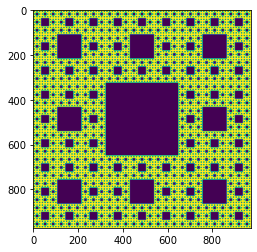

In [7]:
im = sierpinski_foam(4, 5)
plt.imshow(im)

Finally, apply the box count function and visualize.

In [9]:
def boxcount(im,bins=10,d_min=1,d_max=None):
    r"""   
    Calculates fractal dimension of the image.
    
    This function scans the image using a measuring element 
    and counts the number of pixels or voxels (for a 2-D or 3-D image, 
    respectively) that lay over the edge of a pore [1]_.
    
    Parameters
    ----------
    im : ND-array
        The image of the porous material.
    bins : int or ND-array
        The number of times to iteratively scan the image. The default is 10. 
        If an array is entered, this is directly taken as the measuring 
        element sizes. 
    d_min : int
        The size of the smallest measuring element. Measuring elements are 
        taken as a square or a cube. 
    d_max : int
        The size of the largest measuring element. Measuring elements are 
        taken as a square or a cube. 
        
    Returns
    -------
    Ds : ND-array
        The measuring element sizes. This array has 'bins'-number of elements.
    N : ND-array
        The number of pixels or voxels that lay over the edge of a pore, 
        corresponding to each measuring element size. 
    slope: ND-array
        The gradient of N. This array has the same number of elements as Ds and N.
    
    
    References
    ----------
    [1] See Boxcounting on `Wikipedia <https://en.wikipedia.org/wiki/Box_counting>`_

    """
    from collections import namedtuple
    
    im = np.array(im,dtype=bool)    
        
    if (len(im.shape) != 2 and len(im.shape) != 3):
        print('Image must be 2-dimensional or 3-dimensional')
        return      
        
    if isinstance(bins,int):
        Ds = np.unique(np.logspace(1, np.log10(min(im.shape)), bins).astype(int))
    else: 
        Ds = np.array(bins).astype(int)
        
    N=[]       
    for d in tqdm(Ds):
        result = 0
        for i in range(0, im.shape[0], d):
            for j in range(0, im.shape[1], d):
                if len(im.shape) == 2:
                    temp = im[i:i+d,j:j+d] 
                    result += np.any(temp)
                    result -= np.all(temp)
                else:
                    for k in range(0, im.shape[2],d):
                        temp = im[i:i+d, j:j+d, k:k+d]
                        result += np.any(temp)
                        result -= np.all(temp)            
        N.append(result)
    slope = -1*np.gradient(np.log(np.array(N)),np.log(Ds))
    data = namedtuple("data",("size","count","slope"))
    data.size = Ds
    data.count = N
    data.slope = slope
    return data


In [11]:
data = boxcount(im)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.52it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

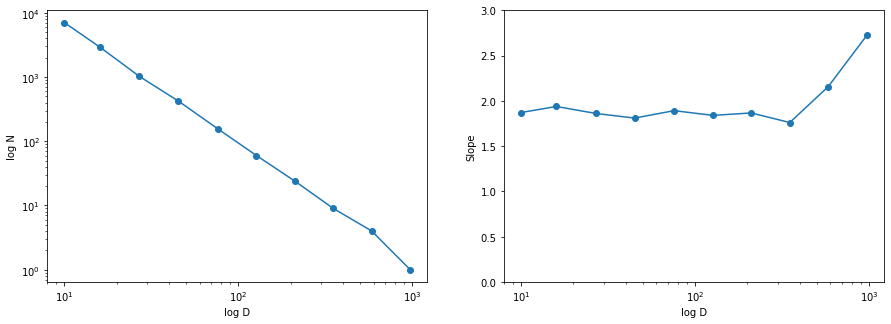

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('log D')
ax1.set_ylabel('log N')
ax2.set_xlabel('log D')
ax2.set_ylabel('Slope')
ax2.set_xscale('log')
ax1.plot(data.size, data.count,'-o')
ax2.plot(data.size,data.slope,'-o')
plt.ylim([0, 3])
plt.show 